In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [119]:
# clean data
data = pd.read_csv('original_data.csv', index_col=0)
data = data.drop('AppointmentID', axis=1)
data.rename(columns = {'Hipertension':'Hypertension','Handcap':'Handicap','No-show':'Noshow'}, inplace=True)
data.Gender = [1 if i=='M' else 0 for i in data.Gender]
data.Noshow = [1 if i=='Yes' else 0 for i in data.Noshow]
data.ScheduledDay = data.ScheduledDay.apply(np.datetime64)
data.AppointmentDay = data.AppointmentDay.apply(np.datetime64)
data['ScheduledHour'] = data.ScheduledDay.apply(lambda x: x.hour)
data['Scheduled'] = data.ScheduledDay.apply(lambda x: x.date())
data['Appointment'] = data.AppointmentDay.apply(lambda x: x.date())
data['DaysSchedToAppt'] = data.Appointment - data.Scheduled
data.DaysSchedToAppt = data.DaysSchedToAppt.apply(lambda x: x.days)
data = data.drop(['Scheduled', 'Appointment', 'ScheduledDay', 'AppointmentDay'], axis=1)
data = data[(data.Age>=0) & (data.Age<=95)]
#data.to_csv('cleaned_data.csv')
print(data.shape)
data.head()

(110480, 12)


,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,Noshow,ScheduledHour,DaysSchedToAppt
PatientId,,,,,,,,,,,,
2.987250e+13,0,62,JARDIM DA PENHA,0,1,0,0,0,0,0,18,0
5.589978e+14,1,56,JARDIM DA PENHA,0,0,0,0,0,0,0,16,0
4.262962e+12,0,62,MATA DA PRAIA,0,0,0,0,0,0,0,16,0
8.679512e+11,0,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,17,0
8.841186e+12,0,56,JARDIM DA PENHA,0,1,1,0,0,0,0,16,0


In [120]:
print ("{}% of the patients were no-shows.".format(round(100*sum(data.Noshow)/data.shape[0],2)))

20.2% of the patients were no-shows.


In [121]:
# get neighborhood dummy variables
data = pd.get_dummies(data, columns=['Neighbourhood'])
print(data.shape)

(110480, 92)


### Regress against features

In [122]:
def feature_probs(data, feature):
    featurevals, probs = sorted(set(data[feature])), []
    for featureval in featurevals:
        df = data[data[feature] == featureval]
        prob = df.Noshow.sum()/df.shape[0]
        probs.append(prob)
    return pd.DataFrame({feature:featurevals, 'probs':probs})

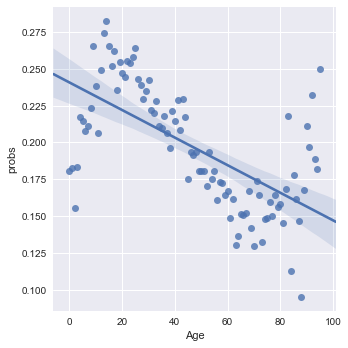

In [124]:
sns.lmplot(x='Age', y='probs', data=feature_probs(data, 'Age'))
plt.show()

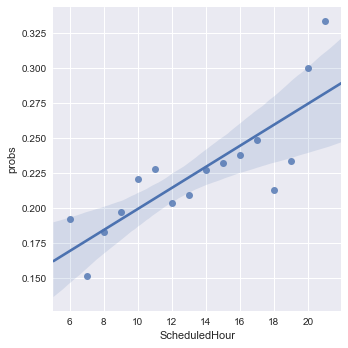

In [128]:
sns.lmplot(x='ScheduledHour', y='probs', data=feature_probs(data, 'ScheduledHour'))
plt.show()

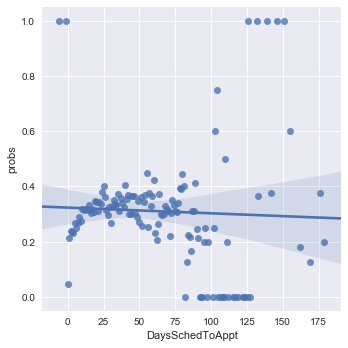

In [129]:
sns.lmplot(x='DaysSchedToAppt', y='probs', data=feature_probs(data, 'DaysSchedToAppt'))
plt.show()

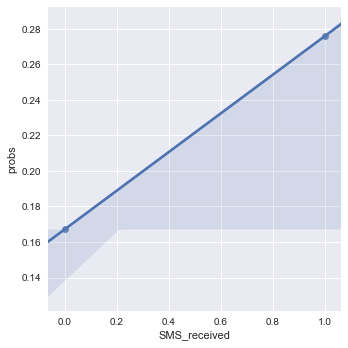

In [131]:
sns.lmplot(x='SMS_received', y='probs', data=feature_probs(data, 'SMS_received'))
plt.show()

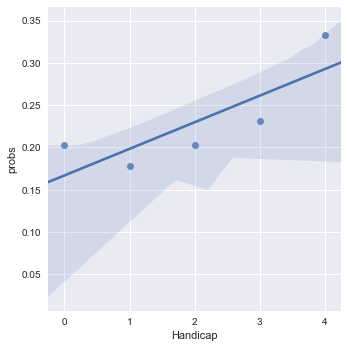

In [132]:
sns.lmplot(x='Handicap', y='probs', data=feature_probs(data, 'Handicap'))
plt.show()

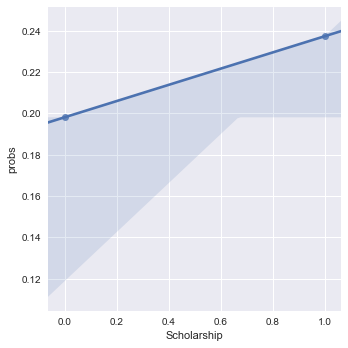

In [133]:
sns.lmplot(x='Scholarship', y='probs', data=feature_probs(data, 'Scholarship'))
plt.show()